### GMM visualization

Using Bishop p.438-439

Author: Teun Mathijssen

In [3]:
%pylab inline

from matplotlib.patches import Ellipse

Populating the interactive namespace from numpy and matplotlib


In [4]:
def mvg2d(x, mu, Sigma):
    """Evaluate 2D Gaussian."""
    return 1 / (2*np.pi * np.sqrt(np.linalg.det(Sigma))) * np.exp(-(x - mu)@np.linalg.inv(Sigma)@(x - mu)/2)

In [13]:
def visualize(iteration, x, mu, Sigma, gamma):
    """Visualize the dataset, the clusters and the cluster responsibilities."""
    # Eigendecompose cluster Sigmas.
    w, v = np.linalg.eigh(Sigma)
    # We want the std values in each direction.
    w = np.sqrt(w)
    
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    
    # We can directly use the gamma values as colors!
    ax.scatter(x[:, 0], x[:, 1], c=gamma, s=30)
    # Want K != 3? Use this line instead to ignore gammas.
#     ax.scatter(x[:, 0], x[:, 1], c="lightgray", s=30)

    # Draw cluster means.
    ax.scatter(mu[:, 0], mu[:, 1], c="white", s=110, edgecolors="black")

    # Draw confidence ellipses for each cluster k.
    for k in np.arange(K):
        # Eigenvectors.
        u1 = v[k, :, 0]
        u2 = v[k, :, 1]
        
        # Eigenvalues.
        l1 = w[k, 0]
        l2 = w[k, 1]
        # Since the eigenvectors are sorted, we can always align the elipse using the first vector.
        # Arctan2 assumes (y, x) as arguments, not (x, y).
        angle = np.arctan2(*u1[::-1])
        
        # Multiply std by 2 because Ellipse requires diameter as argument.
        e = Ellipse(mu[k], l1*2, l2*2, angle=angle*180/np.pi, facecolor="none", edgecolor="black")
        ax.add_patch(e)
            
        # Draw cross using the (sqrt of the) eigenvalues.
        ax.arrow(*mu[k], *u1 * l1)
        ax.arrow(*mu[k], *u1 * -l1)
        ax.arrow(*mu[k], *u2 * l2)
        ax.arrow(*mu[k], *u2 * -l2)
    
    ax.set_aspect("equal")
    ax.set_title("L = " + str(iteration))
    
    plt.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0)
    plt.show()
    
def calc_data_log_ll(x, mu, Sigma, pi):
    """Calculate the data log likelihood."""
    data_log_ll = 0
    for n in np.arange(N):
        ll = 0
        for k in np.arange(K):
            ll += pi[k] * mvg2d(x[n], mu[k], Sigma[k])
            
        data_log_ll += np.log(ll)
        
    return data_log_ll

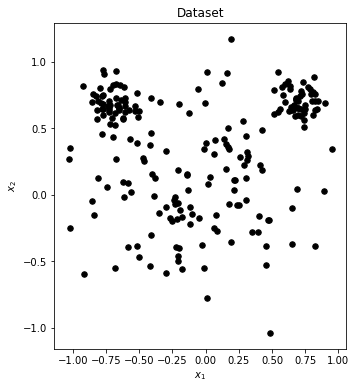

In [14]:
nDims = 2

cov = np.eye(nDims)

# Generate mouse-like dataset.
x = np.array(np.vstack((np.random.multivariate_normal([0, 0], 0.16*cov, 120),
    np.random.multivariate_normal([-0.7, 0.7], 0.01*cov, 50),
    np.random.multivariate_normal([0.7, 0.7], 0.01*cov, 50))), dtype=np.float32)

# # Generate three very unbalanced clusters.
# x = np.array(np.vstack((np.random.multivariate_normal([-1, -1], 0.12*cov, 100),
#     np.random.multivariate_normal([-1, 1], 0.1*cov, 25),
#     np.random.multivariate_normal([1, 1], 0.12*cov, 60))), dtype=np.float32)

N = x.shape[0]

fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(111)
ax.scatter(x[:, 0], x[:, 1], color="black", s=30)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_aspect("equal")
ax.set_title("Dataset")

plt.show()

### Running instructions

Keep the output of the cell below expanded and press `shift + enter` to see the plots as soon as they are generated.

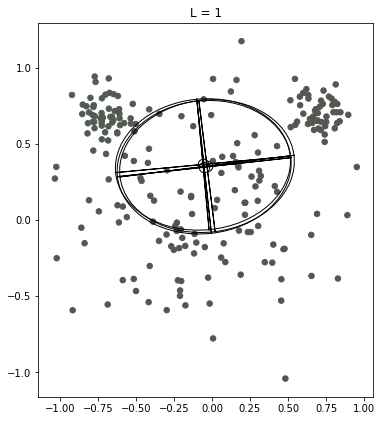

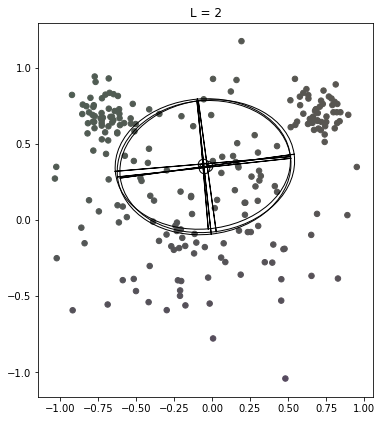

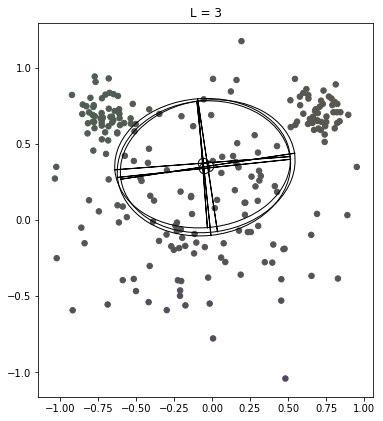

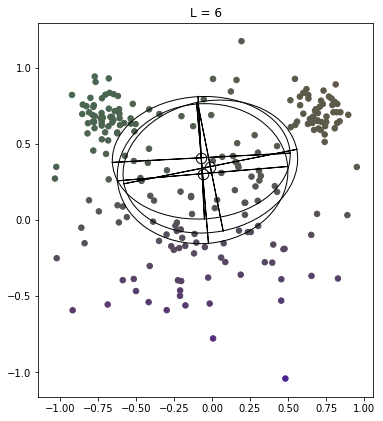

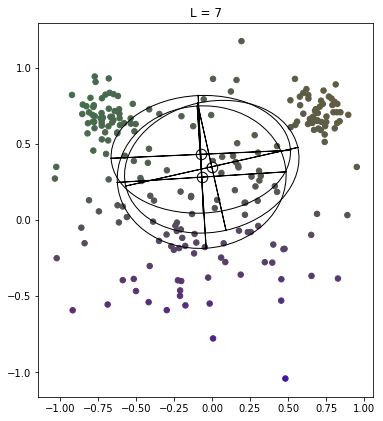

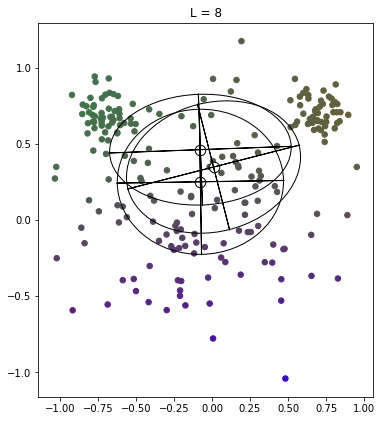

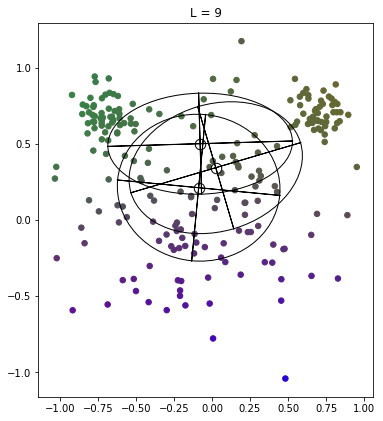

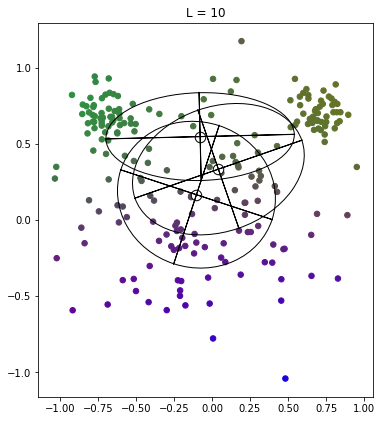

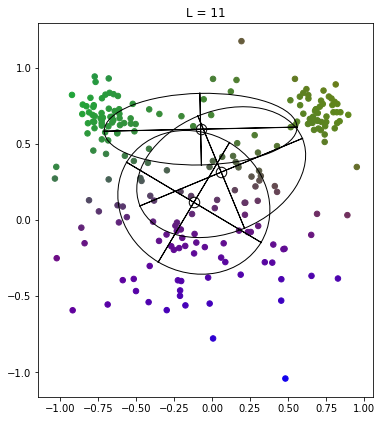

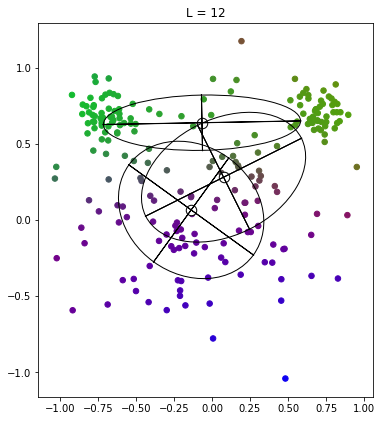

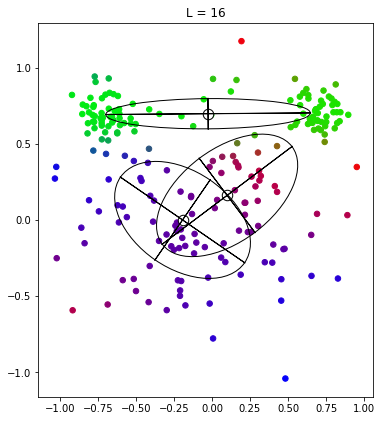

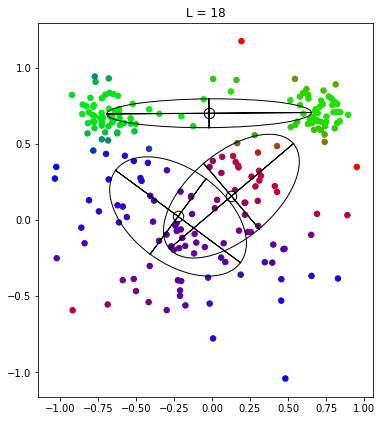

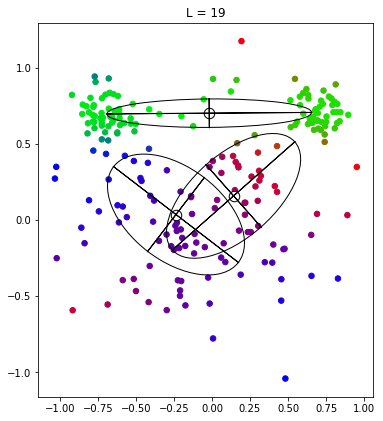

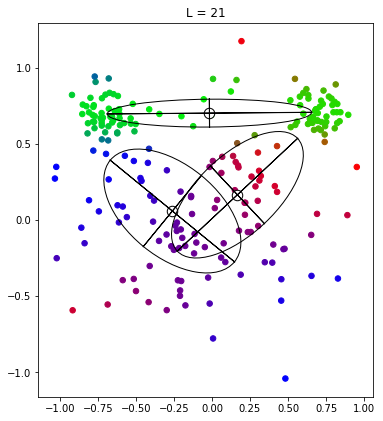

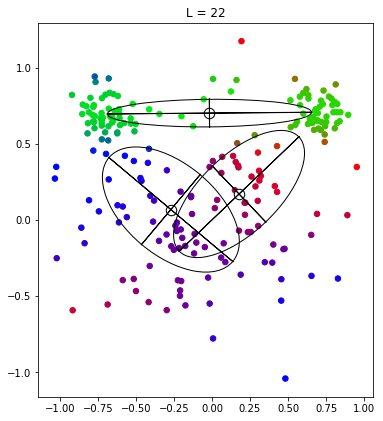

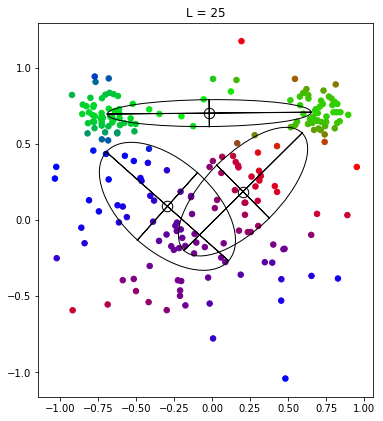

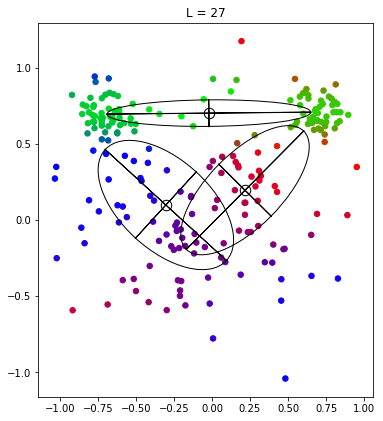

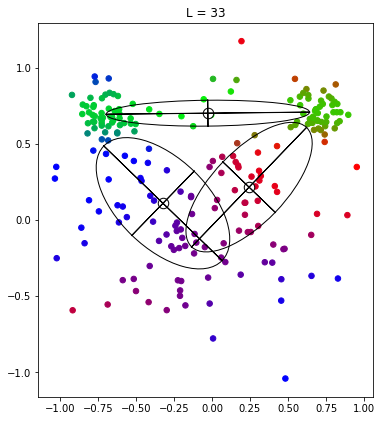

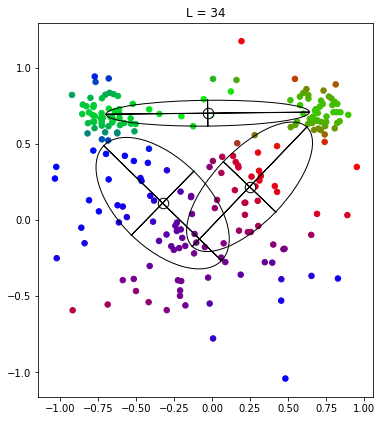

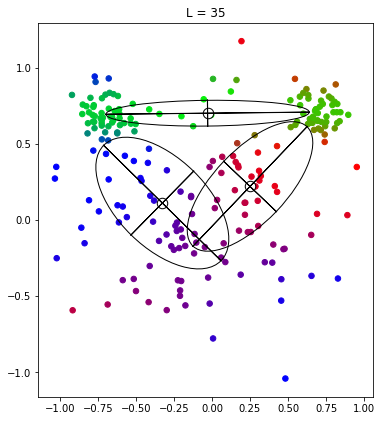

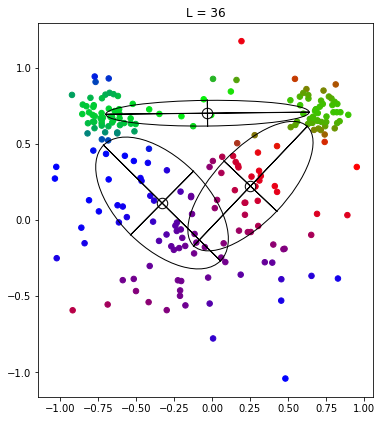

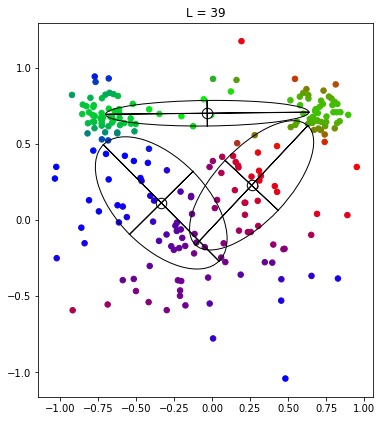

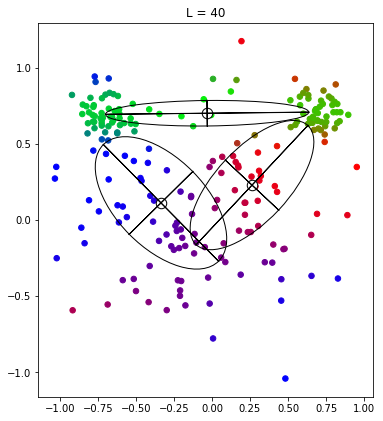

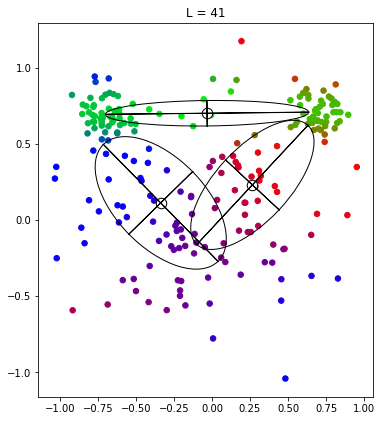

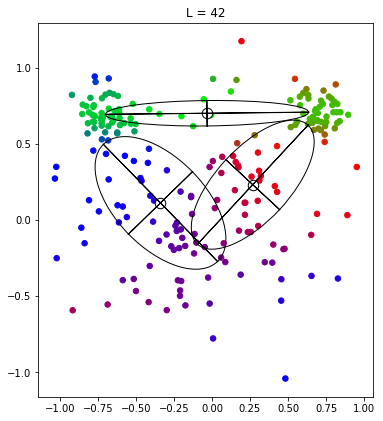

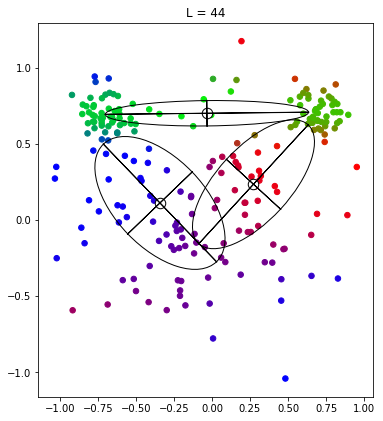

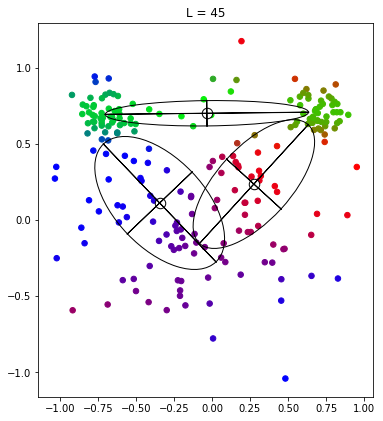

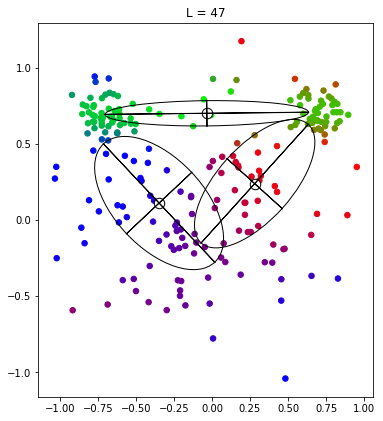

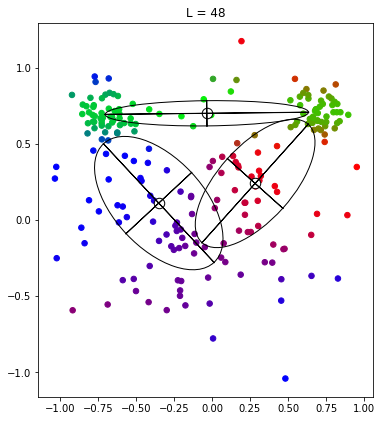

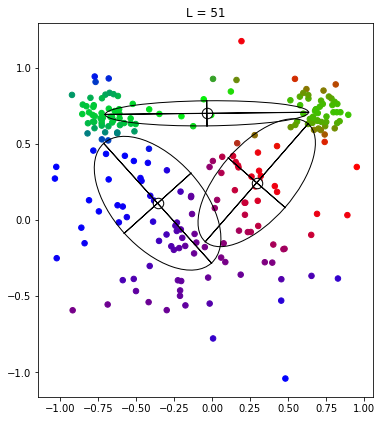

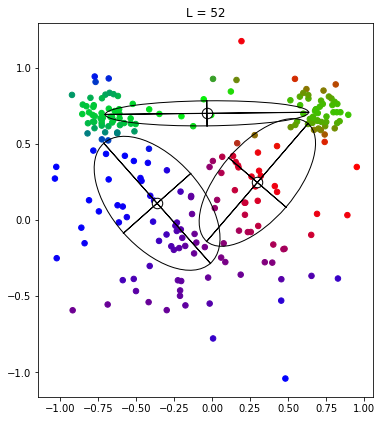

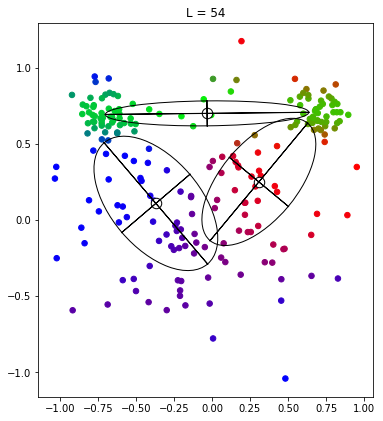

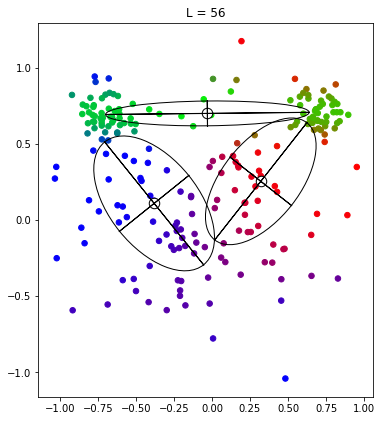

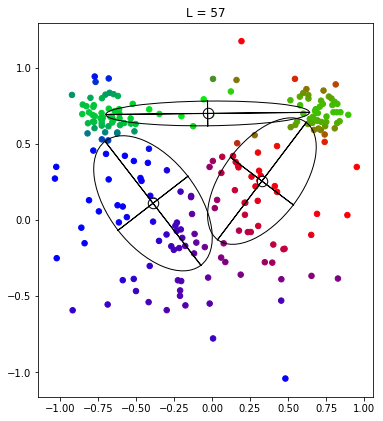

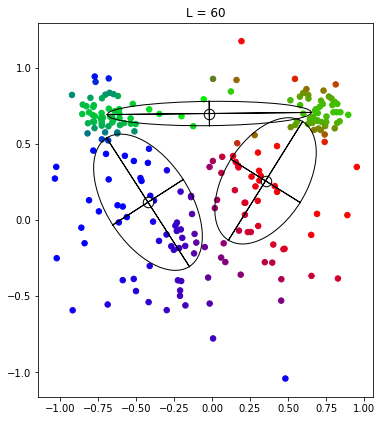

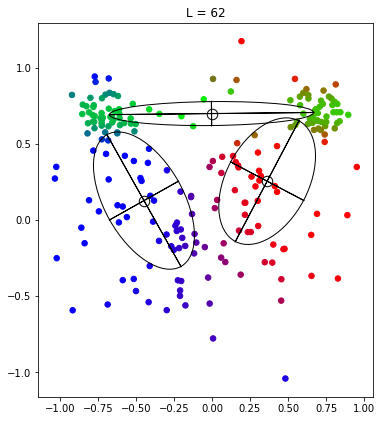

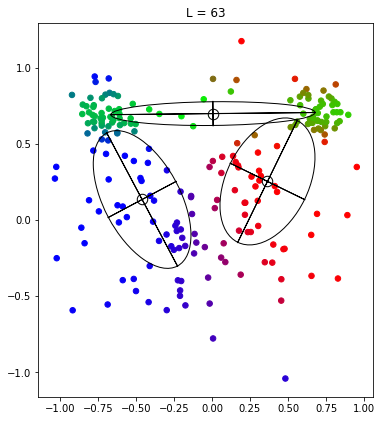

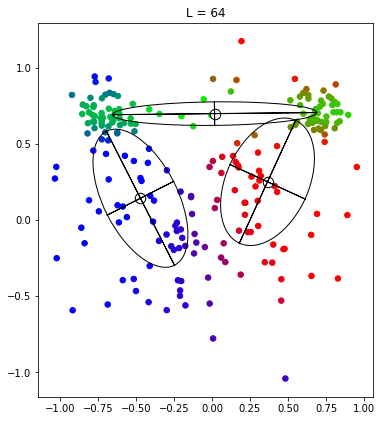

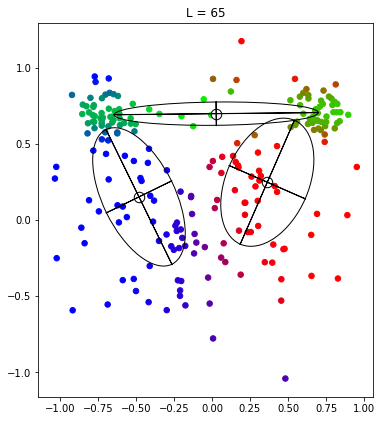

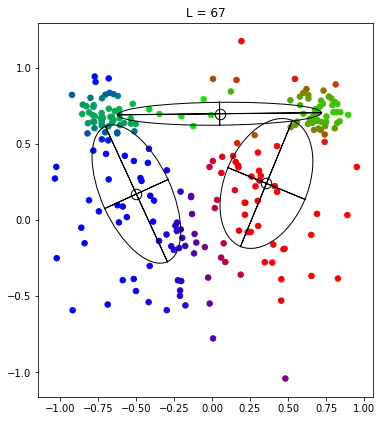

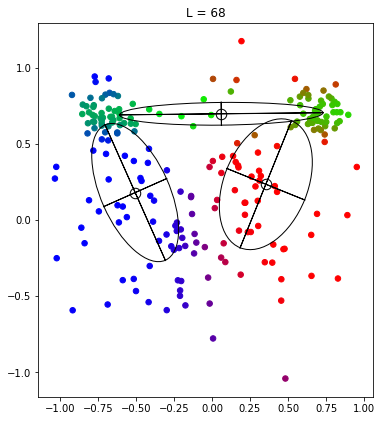

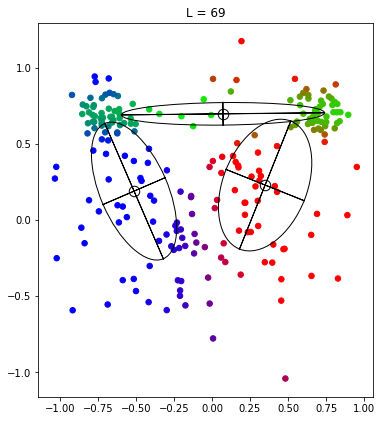

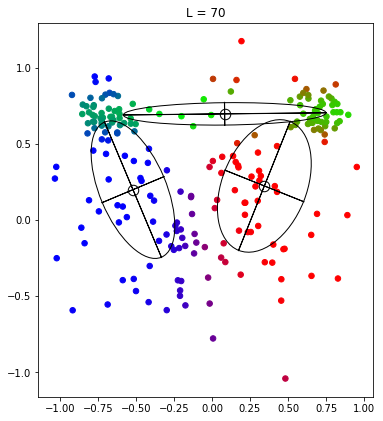

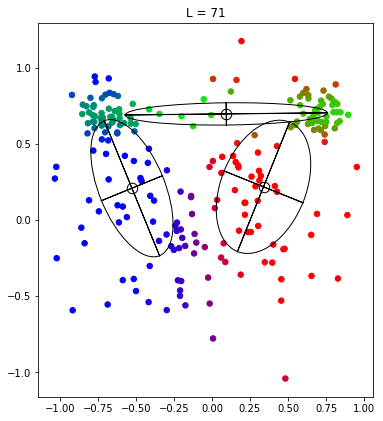

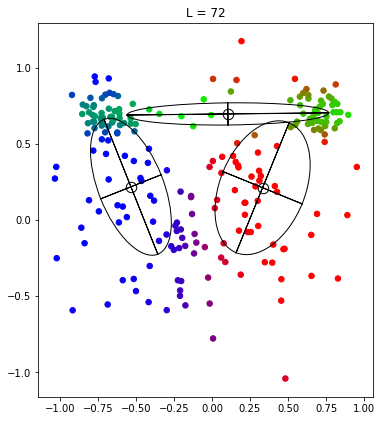

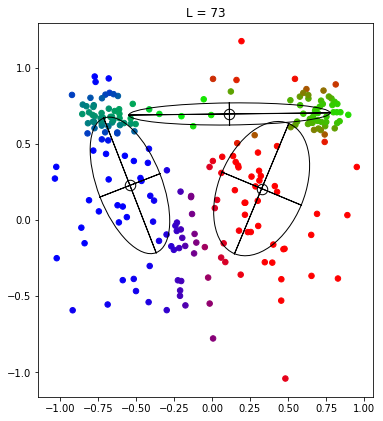

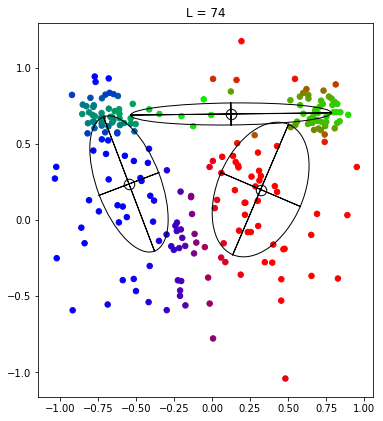

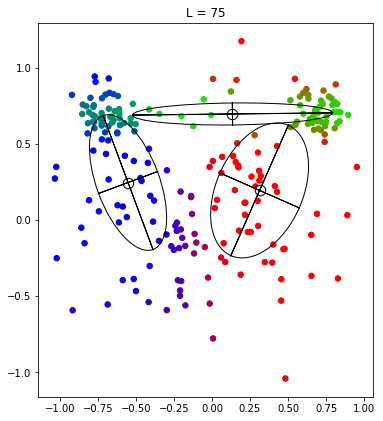

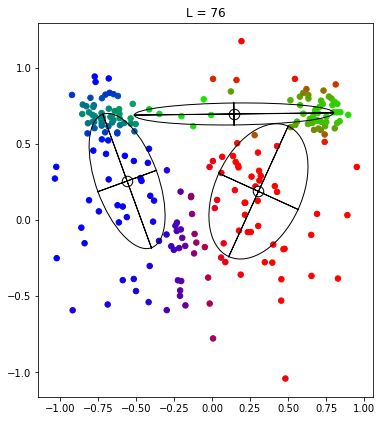

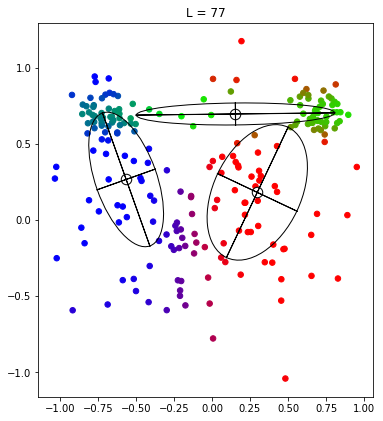

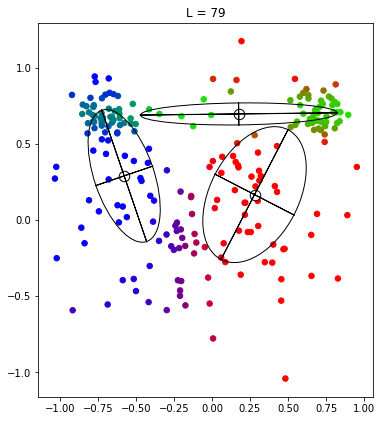

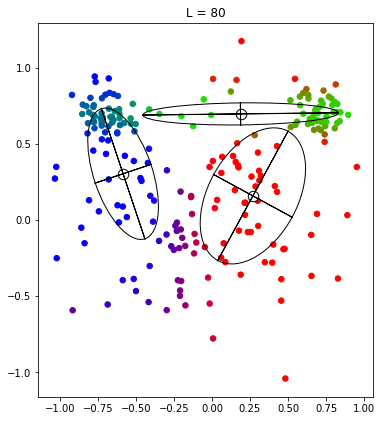

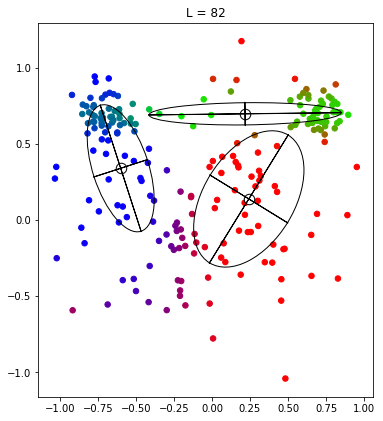

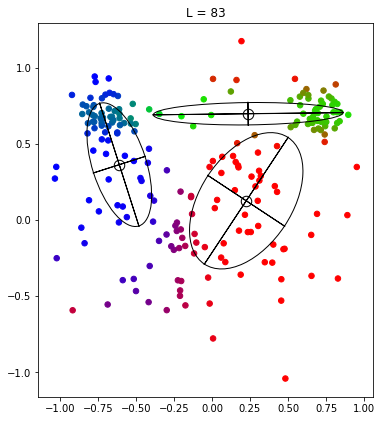

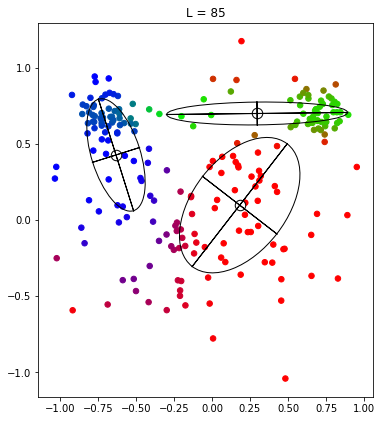

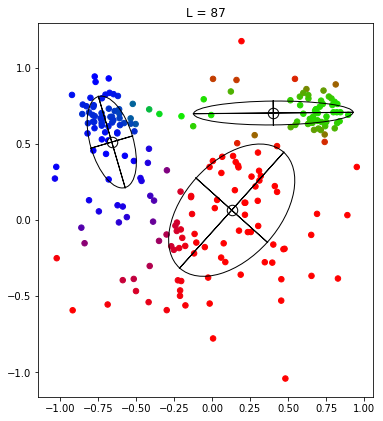

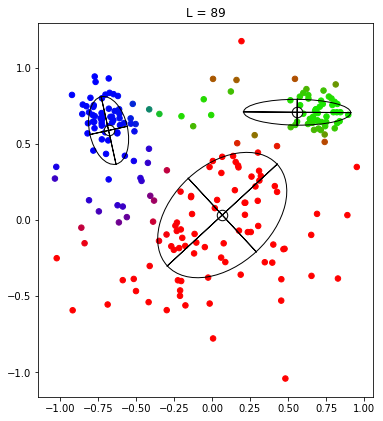

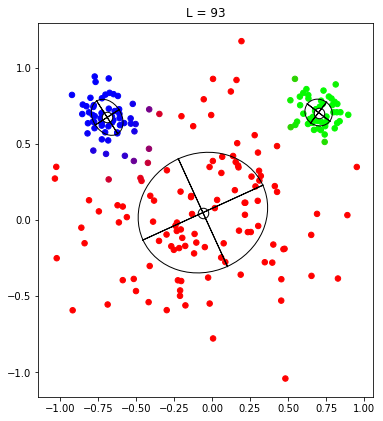

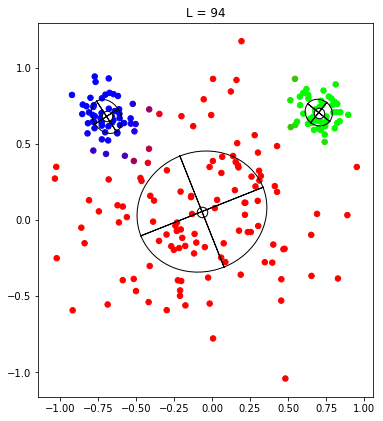

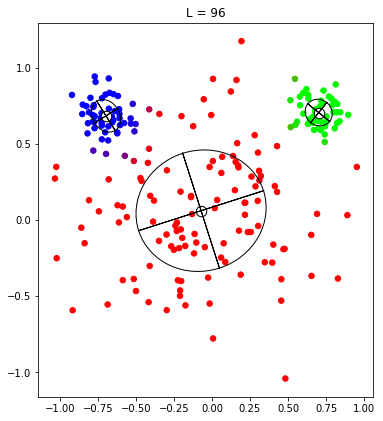

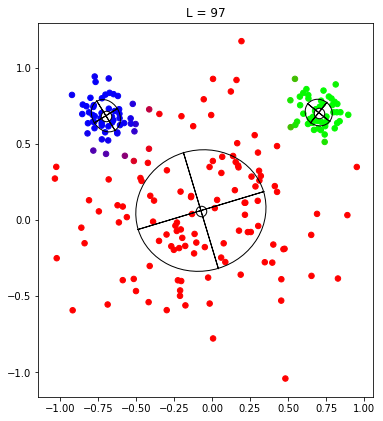

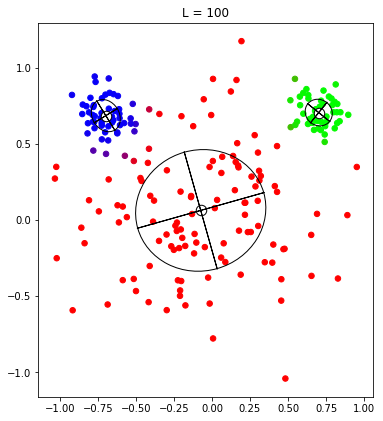

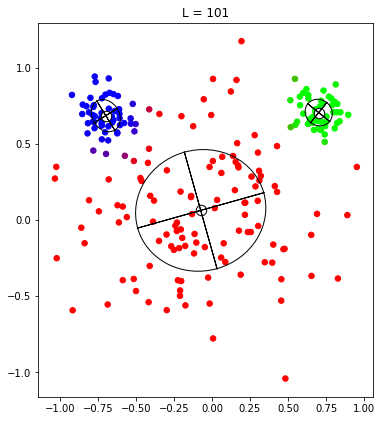

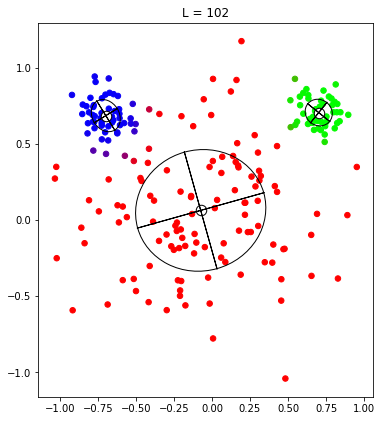

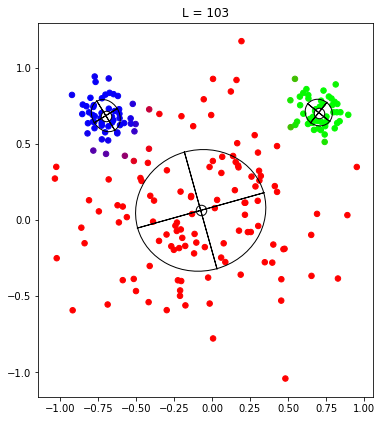

In [15]:
# Use 3 classes for RGB plotting.
K = 3

# Store data log likelihoods.
data_log_lls = []

# Initialize pi_k.
pi = np.ones(K) / K

# Initialize mu_k.
mu = np.random.normal(0, 0.02, (K, nDims))

# Initialize Sigma_k.
Sigma = np.repeat(np.eye(2)[np.newaxis], K, axis=0) / K

# Use fake gammas for initial visualization.
gamma = np.ones((N, K)) / K
visualize(0, x, mu, Sigma, gamma)
data_log_lls.append(calc_data_log_ll(x, mu, Sigma, pi))

# EM algorithm for GMM.
maxIter = 150
for i in np.arange(1, maxIter + 1):
    ### E step.
    # Evaluate gamma_{nk}.
    gamma = np.zeros((N, K))

    for n in np.arange(N):
        # Evaluate the norm factor in the denominator.
        gammaNorm = 0
        for j in np.arange(K):
            gammaNorm += pi[j] * mvg2d(x[n], mu[j], Sigma[j])

        # Calculate the responsibilities for this datapoint.
        for k in np.arange(K):
            gamma[n][k] = pi[k] * mvg2d(x[n], mu[k], Sigma[k]) / gammaNorm

    ### M step.
    # Calculate N_k.
    Nk = np.sum(gamma, axis=0)
    # Estimate pi_k^{new}.
    pi = Nk / N
                
    for k in np.arange(K):
        # Estimate mu_k^{new}.
        muSum = np.zeros(nDims)
        for n in np.arange(N):
            muSum += gamma[n][k] * x[n]
            
        mu[k] = muSum / Nk[k]
        
        # Estimate sigma_k^{new}.
        SigmaSum = np.zeros((nDims, nDims))
        for n in np.arange(N):
            xm = x[n] - mu[k]
            SigmaSum += gamma[n][k] * np.outer(xm, xm)
                        
        Sigma[k] = SigmaSum / Nk[k]
    
    visualize(i, x, mu, Sigma, gamma)
    data_log_lls.append(calc_data_log_ll(x, mu, Sigma, pi))
    
    # Convergence criterium. No need for abs because of guaranteed convergence.
    if data_log_lls[-1] - data_log_lls[-2] < 1e-5:
        break

# Plot data log likelihood.
plt.figure(figsize=(12, 4))
plt.plot(data_log_lls, color="red", marker="x", markersize=6, linewidth=1)
plt.xlabel("L")
plt.ylabel("ln $p$")
plt.grid()
plt.title("Plot of ln $p(X|\mu, \Sigma, \pi)$")

plt.show()